# Variational Autoencoder - CIFAR-10 and TensorFlow2

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-02-21 21:25:36.060697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 21:25:36.081590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 21:25:36.081678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 21:25:36.082870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Data preprocessing and cleaning:

In [5]:
# input image dimensions
img_rows, img_cols = 32, 32

In [6]:
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [8]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (32, 32, 3)


In [9]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100

In [10]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks work best when each input is inside the range –1 to 1, so we need to divide by 255.

In [11]:
# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [12]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


In [13]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(50000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size = batch_size)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

2022-02-21 21:25:37.882051: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 21:25:37.885582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 21:25:37.886147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 21:25:37.886579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

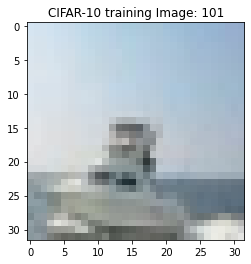

In [14]:
# Visualize one CIFAR-10 dataset-
img_idx = 100

plt.imshow(X_train[img_idx])
plt.title(f"CIFAR-10 training Image: {img_idx + 1}")
plt.show()

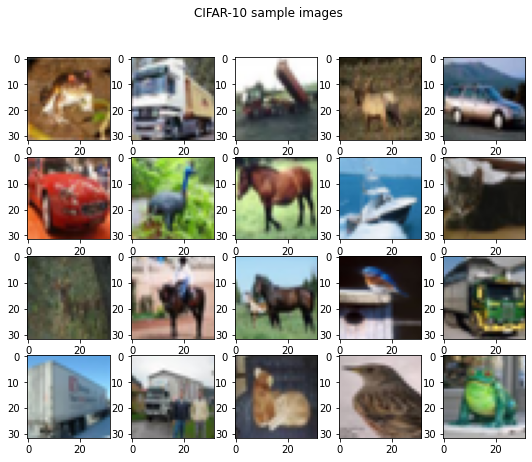

In [15]:
# Visualize 20 CIFAR-10 images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("CIFAR-10 sample images")
plt.show()

### Define _Variational Autoencoder_ architecture

In [16]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
    ):
        super(ConvBlock, self).__init__()
        
        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False,
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
        )
        
    
    def call(self, x):
        x = tf.keras.activations.relu(self.bn(self.conv1(x)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        return x
    

In [17]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim
        
        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )
        
        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()
        
        self.output_layer = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
    
    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_block1(x)
        print(f"conv_block1.shape: {x.shape}")
        x = self.conv_block2(x)
        print(f"conv_block2.shape: {x.shape}")
        x = self.conv_block3(x)
        print(f"conv_block3.shape: {x.shape}")
        x = self.flatten(x)
        print(f"flattened shape: {x.shape}")
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        print(f"Encoder output shape: {x.shape}")
        '''
        Input shape: (64, 32, 32, 3)
        conv_block1.shape: (64, 14, 14, 64)
        conv_block2.shape: (64, 5, 5, 128)
        conv_block3.shape: (64, 2, 2, 256)
        flattened shape: (64, 1024)
        Encoder output shape: (64, 100)
        '''
        
        return None
    

In [18]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim
        
        # self.inp_layer = InputLayer(input_shape = self.latent_dim)
        
        self.dense0 = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn0 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.dense = Dense(
            units = 1024, activation = None
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.dense2 = Dense(
            units = 4 * 4 * 256, activation = None
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.reshape = Reshape((4, 4, 256))
        
        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
       
        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
       
        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn8 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
    
    def call(self, X):
        # X = self.inp_layer(X)
        X = tf.keras.activations.relu(self.bn0(self.dense0(X)))
        X = tf.keras.activations.relu(self.bn(self.dense(X)))
        X = tf.keras.activations.relu(self.bn2(self.dense2(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer1(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer3(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn8(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.sigmoid(self.final_conv_layer(X))
        X = self.final_conv_layer(X)

        return X
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn0(self.dense0(x)))
        print(f"first dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn(self.dense(x)))
        print(f"second dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"third dense layer shape: {x.shape}")
        x = self.reshape(x)
        print(f"reshape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.conv_transpose_layer1(x)))
        print(f"conv transpose layer1 shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.conv_transpose_layer2(x)))
        print(f"conv transpose layer2 shape: {x.shape}")
        x = tf.nn.relu(self.bn5(self.conv_transpose_layer3(x)))
        print(f"conv transpose layer3 shape: {x.shape}")
        x = tf.nn.relu(self.bn6(self.conv_transpose_layer4(x)))
        print(f"conv transpose layer4 shape: {x.shape}")
        x = tf.nn.relu(self.bn7(self.conv_transpose_layer5(x)))
        print(f"conv transpose layer5 shape: {x.shape}")
        x = tf.nn.relu(self.bn8(self.conv_transpose_layer6(x)))
        print(f"conv transpose layer6 shape: {x.shape}")
        x = self.final_conv_layer(x)
        print(f"Decoder output shape: {x.shape}")
        
        '''
        Input shape: (64, 100)
        first dense layer shape: (64, 100)
        second dense layer shape: (64, 1024)
        third dense layer shape: (64, 4096)
        reshape: (64, 4, 4, 256)
        conv transpose layer1 shape: (64, 8, 8, 256)
        conv transpose layer2 shape: (64, 8, 8, 256)
        conv transpose layer3 shape: (64, 16, 16, 128)
        conv transpose layer4 shape: (64, 16, 16, 128)
        conv transpose layer5 shape: (64, 32, 32, 64)
        conv transpose layer6 shape: (64, 32, 32, 64)
        Decoder output shape: (64, 32, 32, 3)
        '''
        
        return None
        

#### Sanity check

In [19]:
encoder = Conv6_Encoder(latent_dim = 100)

In [20]:
decoder = Conv6_Decoder(latent_dim = 100)

In [21]:
x = next(iter(train_dataset))

In [22]:
x.shape

TensorShape([64, 32, 32, 3])

In [23]:
x_enc = encoder(x)

2022-02-21 21:25:43.052127: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301
2022-02-21 21:25:43.880763: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [24]:
x_recon = decoder(x_enc)

In [25]:
x_enc.shape

TensorShape([64, 100])

In [26]:
x.shape, x_recon.shape

(TensorShape([64, 32, 32, 3]), TensorShape([64, 32, 32, 3]))

In [27]:
encoder.shape_computation(x)

Input shape: (64, 32, 32, 3)
conv_block1.shape: (64, 14, 14, 64)
conv_block2.shape: (64, 5, 5, 128)
conv_block3.shape: (64, 2, 2, 256)
flattened shape: (64, 1024)
Encoder output shape: (64, 100)


In [28]:
decoder.shape_computation(x_enc)

Input shape: (64, 100)
first dense layer shape: (64, 100)
second dense layer shape: (64, 1024)
third dense layer shape: (64, 4096)
reshape: (64, 4, 4, 256)
conv transpose layer1 shape: (64, 8, 8, 256)
conv transpose layer2 shape: (64, 8, 8, 256)
conv transpose layer3 shape: (64, 16, 16, 128)
conv transpose layer4 shape: (64, 16, 16, 128)
conv transpose layer5 shape: (64, 32, 32, 64)
conv transpose layer6 shape: (64, 32, 32, 64)
Decoder output shape: (64, 32, 32, 3)


In [29]:
del encoder, decoder, x, x_enc, x_recon

In [30]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (mu, log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard 
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )

        return mu + (tf.exp(0.5 * log_var) * epsilon)


In [31]:
class VAE(Model):
    def __init__(self, latent_space = 100):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        
        self.encoder = Conv6_Encoder(latent_dim = self.latent_space)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)
        
    
    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 100)
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        # z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        z = Sampling()(mu, log_var)
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 100), log_var.shape: (batch_size, 100) & z.shape: (batch_size, 100)
        '''
        
        x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var
    
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))
    
        

In [32]:
# Initialize VAE model-
model = VAE(latent_space = 100)

In [33]:
# Sanity check-
x = next(iter(train_dataset))

In [34]:
# Forward pass using input data-
x_recon, mu, log_var = model(x)

In [35]:
x.shape, x_recon.shape

(TensorShape([64, 32, 32, 3]), TensorShape([64, 32, 32, 3]))

In [36]:
mu.shape, log_var.shape

(TensorShape([64, 100]), TensorShape([64, 100]))

In [37]:
mu.numpy().mean(), mu.numpy().std()

(0.0001422442, 0.0104450425)

In [38]:
log_var.numpy().mean(), log_var.numpy().std()

(-0.0009754725, 0.010586031)

In [39]:
del x, x_recon, mu, log_var

In [40]:
# Get model summary-
model.model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv6__encoder_1 (Conv6_Encode  (None, 100)         1250996     ['input_1[0][0]']                
 r)                                                                                               
                                                                                                  
 dense_8 (Dense)                (None, 100)          10100       ['conv6__encoder_1[0][0]']       
                                                                                                  
 dense_9 (Dense)                (None, 100)          10100       ['conv6__encoder_1[0][0]']   

In [41]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (3, 3, 3, 64) has 1728 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 64) has 36864 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 128) has 73728 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 128) has 147456 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 256) has 294912 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (3, 3, 256, 256) has 589824 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (1024, 100) has 102400 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 100) has 10000 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 1024) has 102400 parameters
layer: (1024,) has 0 parameters
layer: (1024,

In [42]:
print(f"VAE has {tot_params} trainable parameters")

VAE has 7315062 trainable parameters


In [43]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

### Train VAE CNN based model using _tf.GradientTape()_

In [44]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):
    
    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            # tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            tf.keras.losses.mean_squared_error(data, reconstruction),
            axis = (1, 2)
            )
        )
    
    # KL-divergence loss-    
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            kl_loss,
            axis = 1
        )
    )

    total_loss = (recon_loss * alpha) + kl_loss
    
    return total_loss, recon_loss, kl_loss
    

In [ ]:
'''
total_loss, recon_loss, kl_loss = compute_loss(
    data = X, reconstruction = X_recon,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
# total_loss
# <tf.Tensor: shape=(), dtype=float32, numpy=0.23451519>

In [46]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


In [47]:
@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )
    
    return total_loss, recon_loss, kl_loss


In [48]:
print(f"Train VAE model for {num_epochs} epochs")

Train VAE model for 100 epochs


In [49]:
# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [50]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 10

In [ ]:
# Initialize parameters for Early Stopping manual implementation-
# best_val_loss = 10000
# loc_patience = 0

In [36]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [51]:
for epoch in range(1, num_epochs + 1):
    """
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    """

    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0
    
    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha
        )
        
        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()
    
    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)
        
        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()
    
    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }
    
    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )
    
    '''
    # Save 'best' model so far-
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Saving VAE model with val_los = {val_loss:.4f}")
        model.save_weights("VAE_CIFAR10_best_model.h5", overwrite = True)
    ''' 

    """
    # Code for manual Early Stopping:
    # if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        model.save_weights("VAE_CIFAR10_best_model.h5", overwrite = True)
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    """



epoch = 1; total train loss = 350839.6912, train recon loss = 33850.7825, train kl loss = 12331.8664; total val loss = 57129.7843, val recon loss = 5343.9223 & val kl loss = 3690.5610
epoch = 2; total train loss = 265246.0246, train recon loss = 24278.4539, train kl loss = 22461.4857; total val loss = 50093.1238, val recon loss = 4505.4040 & val kl loss = 5039.0832
epoch = 3; total train loss = 241259.9978, train recon loss = 21535.1126, train kl loss = 25908.8716; total val loss = 47891.3392, val recon loss = 4280.4497 & val kl loss = 5086.8423
epoch = 4; total train loss = 229824.3193, train recon loss = 20368.1153, train kl loss = 26143.1666; total val loss = 44860.4744, val recon loss = 3925.6205 & val kl loss = 5604.2690
epoch = 5; total train loss = 211674.7252, train recon loss = 18302.2756, train kl loss = 28651.9695; total val loss = 41302.0391, val recon loss = 3566.4360 & val kl loss = 5637.6791
epoch = 6; total train loss = 203374.7651, train recon loss = 17473.9480, train 

In [52]:
# Sanity check for Python3 dicts containing training metrics-
training_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

In [53]:
val_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

In [54]:
training_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [55]:
val_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [56]:
# Save trained model at the end of training-
model.save_weights("VAE_CIFAR10_last_epoch.h5", overwrite = True)

In [57]:
import pickle

# Save training metrics as pickle file-
with open("VAE_CIFAR10_training_metrics.pkl", "wb") as file:
    pickle.dump(training_metrics, file)

In [58]:
# Save validation metrics as pickle file-
with open("VAE_CIFAR10_training_metrics.pkl", "wb") as file:
    pickle.dump(val_metrics, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_CIFAR10_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

### Visualize training metrics

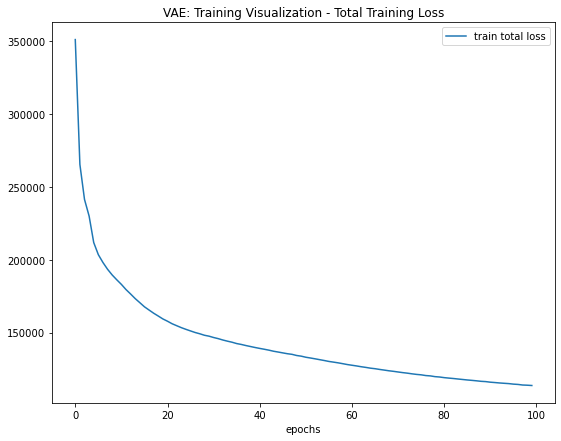

In [59]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

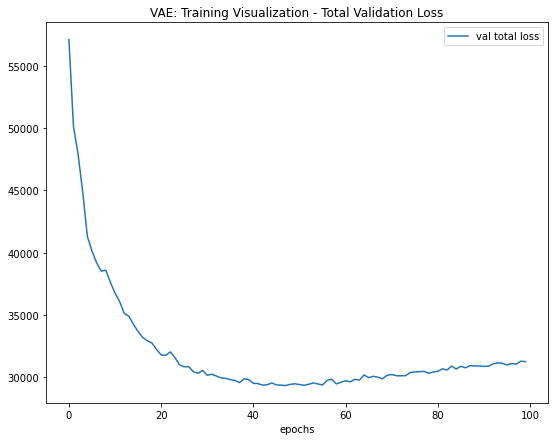

In [60]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['total_loss'] for e in val_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

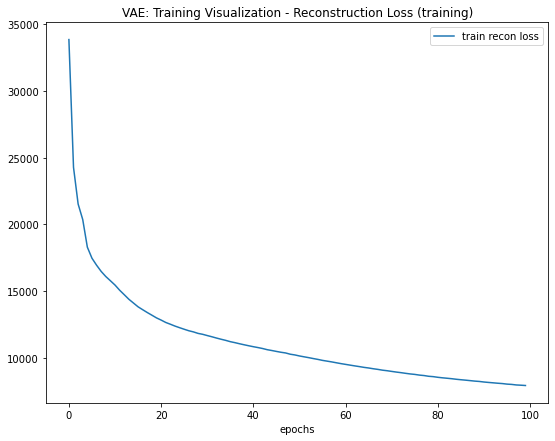

In [61]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

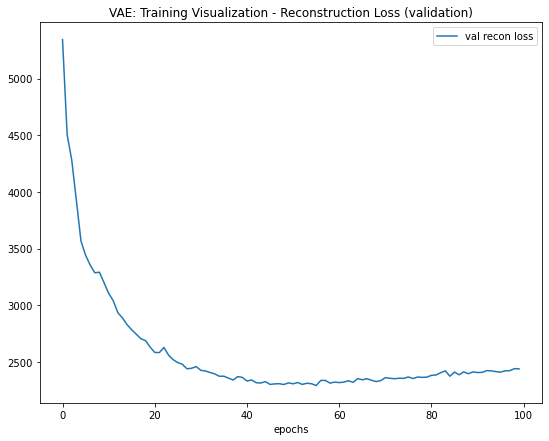

In [62]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['recon_loss'] for e in val_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

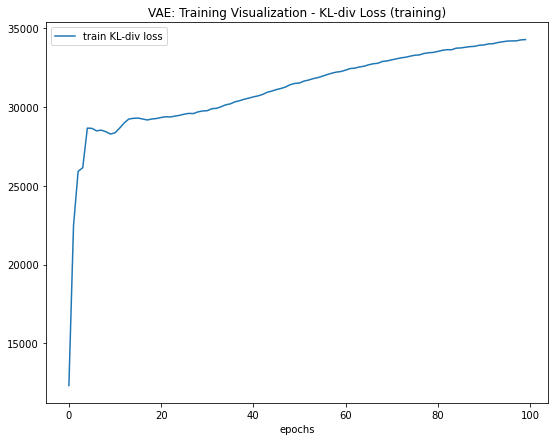

In [63]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

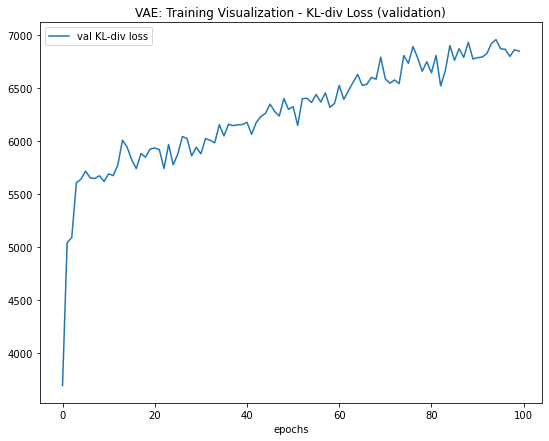

In [64]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['kl_loss'] for e in val_metrics.keys()], label = 'val KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

### Visualize _reconstructions_ using trained VAE model

In [65]:
# Get reconstructions, mean & log-variance from trained model-
X_train_reconstruced, mu, log_var = model(X_train[:1000, :])

In [66]:
# Sanity check-
X_train[:1000, :].shape, X_train_reconstruced.shape

((1000, 32, 32, 3), TensorShape([1000, 32, 32, 3]))

In [ ]:
'''
X_train_reconstruced = tf.reshape(
    tensor = X_train_reconstruced,
    shape = ((X_train_reconstruced.shape[0], X_train_reconstruced.shape[1], X_train_reconstruced.shape[2] )),
    name = None
    )
'''

In [67]:
# Sanity check-
X_train_reconstruced.numpy().shape

(1000, 32, 32, 3)

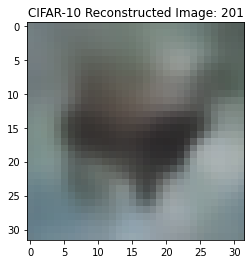

In [68]:
# Visualize one of reconstructed CIFAR-10 image-
img_idx = 200

plt.imshow(X_train_reconstruced[img_idx])
plt.title(f"CIFAR-10 Reconstructed Image: {img_idx + 1}")
plt.show()

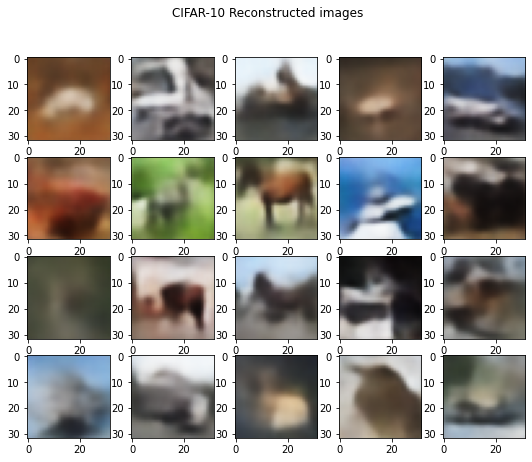

In [78]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i])
    
plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images2.png')
plt.show()

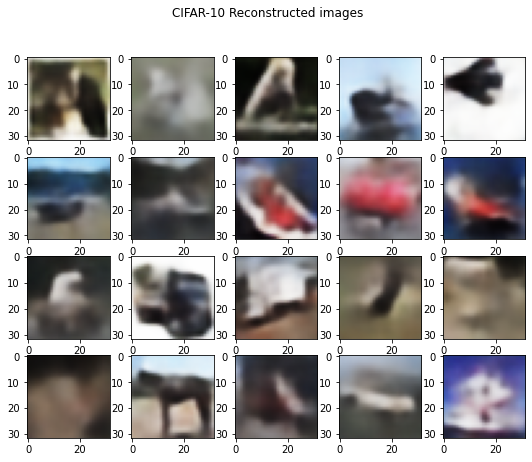

In [79]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i + 500])
    
plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images3.png')
plt.show()

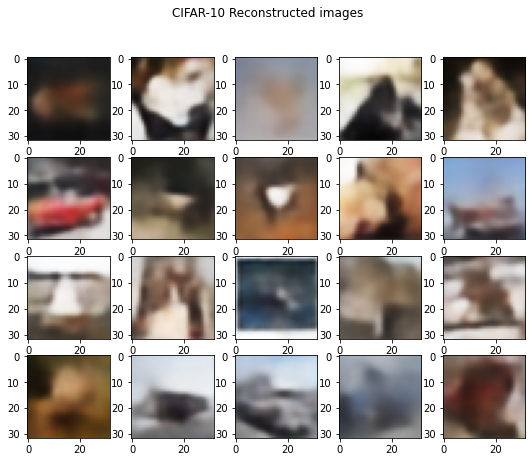

In [80]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i + 850])
    
plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images4.png')
plt.show()

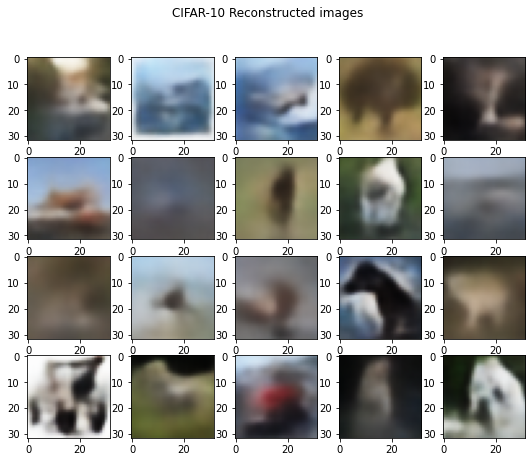

In [81]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i + 900])
    
plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images5.png')
plt.show()

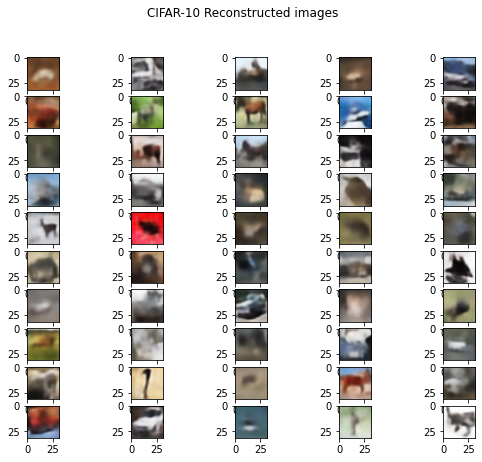

In [69]:
# Visualize 50 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(50):
    # 10 rows & 5 columns-
    plt.subplot(10, 5, i + 1)
    plt.imshow(X_train_reconstruced[i])
    
plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images.png')
plt.show()

#### Check _mu_ and _log_var_ latent space vectors:

In [82]:
mu.shape, log_var.shape

(TensorShape([1000, 100]), TensorShape([1000, 100]))

In [83]:
print(f"mu: mean = {mu.numpy().mean():.4f} & "
f"std dev = {mu.numpy().std():.4f}")

mu: mean = -0.0026 & std dev = 0.5161


In [84]:
print(f"log var: mean = {log_var.numpy().mean():4f} &"
f" std dev = {log_var.numpy().std():.4f}")

log var: mean = -0.875684 & std dev = 1.5154


In [85]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [86]:
y_train.shape, y_test.shape

((50000,), (10000,))

### Visualize _mean_ and _log-variance_ of _latent space_ using trained VAE model

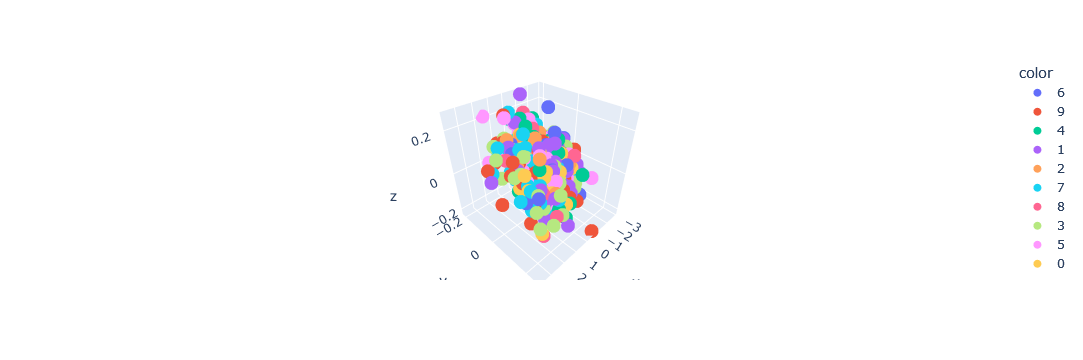

In [87]:
# Visualize  latent space mean-
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    color = y_train[:1000]
    )
fig.show()

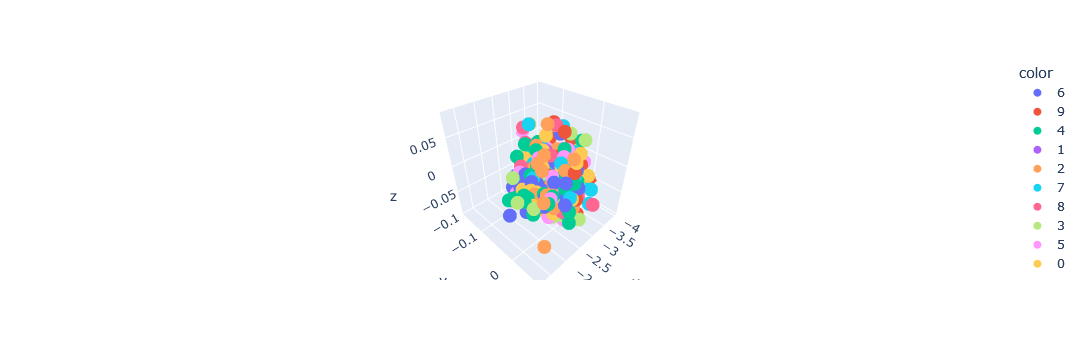

In [88]:
# Visualize  latent space log variance-
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    color = y_train[:1000]
    )
fig.show()

In [89]:
del mu, log_var, X_train_reconstruced

### Visualize _latent space_ of train & test datasets

In [99]:
X_train_encoded = model.encoder(X_train[:5000])
X_test_encoded = model.encoder(X_test[:5000])

In [100]:
X_train_encoded.shape, X_test_encoded.shape

(TensorShape([5000, 100]), TensorShape([5000, 100]))

In [103]:
X_train_encoded.numpy().mean(), X_train_encoded.numpy().std()

(1.232008, 1.1569778)

In [104]:
X_test_encoded.numpy().mean(), X_test_encoded.numpy().std()

(1.2328023, 1.1570983)

### Latent Space analysis:

- Interestingly, not all of the latent variables within the latent space learn something meaniningful. Latent variables having mean = 0 and standard deviation = 0 are _use less_ and can be discarded.

- Interestingly, this can lead to designing a better _latent space_ for subsequent experiment(s).

In [114]:
for i in range(100):
    print(f"i: {i} has mean = {X_train_encoded[:, i].numpy().mean():.3f} &"
          f" std dev = {X_train_encoded[:, i].numpy().std():.3f}"
         )

i: 0 has mean = 0.000 & std dev = 0.000
i: 1 has mean = 0.000 & std dev = 0.000
i: 2 has mean = 0.000 & std dev = 0.000
i: 3 has mean = 0.000 & std dev = 0.000
i: 4 has mean = 1.954 & std dev = 0.674
i: 5 has mean = 0.000 & std dev = 0.000
i: 6 has mean = 2.309 & std dev = 0.823
i: 7 has mean = 1.633 & std dev = 0.690
i: 8 has mean = 2.203 & std dev = 0.760
i: 9 has mean = 1.858 & std dev = 0.748
i: 10 has mean = 2.039 & std dev = 0.719
i: 11 has mean = 2.058 & std dev = 0.784
i: 12 has mean = 2.153 & std dev = 0.819
i: 13 has mean = 2.171 & std dev = 0.787
i: 14 has mean = 1.689 & std dev = 0.649
i: 15 has mean = 0.000 & std dev = 0.000
i: 16 has mean = 1.969 & std dev = 0.695
i: 17 has mean = 0.000 & std dev = 0.000
i: 18 has mean = 0.000 & std dev = 0.000
i: 19 has mean = 2.339 & std dev = 0.793
i: 20 has mean = 0.000 & std dev = 0.000
i: 21 has mean = 1.726 & std dev = 0.656
i: 22 has mean = 2.085 & std dev = 0.753
i: 23 has mean = 2.174 & std dev = 0.745
i: 24 has mean = 2.023 & s

Around 35 latent variables can be removed!

In [115]:
for i in range(100):
    print(f"i: {i} has mean = {X_test_encoded[:, i].numpy().mean():.3f} &"
          f" std dev = {X_test_encoded[:, i].numpy().std():.3f}"
         )

i: 0 has mean = 0.000 & std dev = 0.000
i: 1 has mean = 0.000 & std dev = 0.000
i: 2 has mean = 0.000 & std dev = 0.000
i: 3 has mean = 0.000 & std dev = 0.000
i: 4 has mean = 1.951 & std dev = 0.652
i: 5 has mean = 0.000 & std dev = 0.000
i: 6 has mean = 2.284 & std dev = 0.797
i: 7 has mean = 1.625 & std dev = 0.702
i: 8 has mean = 2.230 & std dev = 0.746
i: 9 has mean = 1.836 & std dev = 0.742
i: 10 has mean = 2.054 & std dev = 0.721
i: 11 has mean = 2.063 & std dev = 0.776
i: 12 has mean = 2.127 & std dev = 0.807
i: 13 has mean = 2.154 & std dev = 0.780
i: 14 has mean = 1.684 & std dev = 0.626
i: 15 has mean = 0.000 & std dev = 0.000
i: 16 has mean = 1.952 & std dev = 0.688
i: 17 has mean = 0.000 & std dev = 0.000
i: 18 has mean = 0.000 & std dev = 0.000
i: 19 has mean = 2.355 & std dev = 0.779
i: 20 has mean = 0.000 & std dev = 0.000
i: 21 has mean = 1.710 & std dev = 0.656
i: 22 has mean = 2.121 & std dev = 0.759
i: 23 has mean = 2.163 & std dev = 0.729
i: 24 has mean = 2.046 & s

### Due to high-dimensionality of _latent space_, we need to perform some dimensionality reduction before visualizing it in 3-D

In [ ]:
fig = px.scatter_3d(
    x = X_train_encoded[:, 0], y = X_train_encoded[:, 1],
    z = X_train_encoded[:, 2],
    # color = y_train[:5000]
)
fig.show()

In [ ]:
fig = px.scatter_3d(
    x = X_test_encoded[:, 0], y = X_test_encoded[:, 1],
    z = X_test_encoded[:, 2],
    # color = y_test
)
fig.show()

In [116]:
del X_train_encoded, X_test_encoded